<img src="https://fsdl.me/logo-720-dark-horizontal">

# Lab 01: Deep Neural Networks in PyTorch

### What You Will Learn

- How to write a basic neural network from scratch in PyTorch
- How the submodules of `torch`, like `torch.nn` and `torch.utils.data`, make writing performant neural network training and inference code easier

At its core, PyTorch is a library for
- doing math on arrays
- with automatic calculation of gradients
- that is easy to accelerate with GPUs and distribute over nodes.

Much of the time,
we work at a remove from the core features of PyTorch,
using abstractions from `torch.nn`
or from frameworks on top of PyTorch.

This tutorial builds those abstractions up
from core PyTorch,
showing how to go from basic iterated
gradient computation and application
to a solid training and validation loop.
It is adapted from the PyTorch tutorial
[What is `torch.nn` really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html).

We assume familiarity with the fundamentals of ML and DNNs here,
like gradient-based optimization and statistical learning.
For refreshing on those, we recommend
[3Blue1Brown's videos](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&ab_channel=3Blue1Brown)
or
[the NYU course on deep learning by Le Cun and Canziani](https://cds.nyu.edu/deep-learning/)

# Setup

If you're running this notebook on Google Colab,
the cell below will run full environment setup.

It should take about three minutes to run.

# Getting data and making `Tensor`s

Before we can build a model,
we need data.

The code below uses the Python standard library to download the
[MNIST dataset of handwritten digits](https://en.wikipedia.org/wiki/MNIST_database)
from the internet.

The data used to train state-of-the-art models these days
is generally too large to be stored on the disk of any single machine
(to say nothing of the RAM!),
so fetching data over a network is a common first step in model training.

In [53]:
from pathlib import Path
import requests


def download_mnist(path):
    url = "https://github.com/pytorch/tutorials/raw/main/_static/"
    filename = "mnist.pkl.gz"

    if not (path / filename).exists():
        content = requests.get(url + filename).content
        (path / filename).open("wb").write(content)

    return path / filename


data_path = Path("data") if Path("data").exists() else Path("data")
path = data_path
path.mkdir(parents=True, exist_ok=True)

datafile = download_mnist(path)

Larger data consumes more resources --
when reading, writing, and sending over the network --
so the dataset is compressed
(`.gz` extension).

Each piece of the dataset
(training and validation inputs and outputs)
is a single Python object
(specifically, an array).
We can persist Python objects to disk
(also known as "serialization")
and load them back in
(also known as "deserialization")
using the `pickle` library
(`.pkl` extension).

In [54]:
import gzip
import pickle


def read_mnist(path):
    with gzip.open(path, "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    return x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = read_mnist(datafile)

PyTorch provides its own array type,
the `torch.Tensor`.
The cell below converts our arrays into `torch.Tensor`s.

Very roughly speaking, a "tensor" in ML
just means the same thing as an
"array" elsewhere in computer science.
Terminology is different in
[physics](https://physics.stackexchange.com/a/270445),
[mathematics](https://en.wikipedia.org/wiki/Tensor#Using_tensor_products),
and [computing](https://www.kdnuggets.com/2018/05/wtf-tensor.html),
but here the term "tensor" is intended to connote
an array that might have more than two dimensions.

In [55]:
import torch


x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
import wandb

Tensors are defined by their contents:
they are big rectangular blocks of numbers.

In [56]:
print(x_train, y_train, sep="\n")

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([5, 0, 4,  ..., 8, 4, 8])


Accessing the contents of `Tensor`s is called "indexing",
and uses the same syntax as general Python indexing.
It always returns a new `Tensor`:

In [57]:
y_train[0], x_train[0, ::2]

(tensor(5),
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0117, 0.0703, 0.4922, 0.6836, 0.6484,
         0.9648, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1172, 0.3672,
         0.6641, 0.9883, 0.9883, 0.8789, 0.9883, 0.7617, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.9297, 0.9883, 0.9883, 0.9883, 0.9883, 0.3633,
         0.3203,

PyTorch, like many libraries for high-performance array math,
allows us to quickly and easily access metadata about our tensors.

The most important pieces of metadata about a `Tensor`,
or any array, are its _dimension_
and its _shape_.

The dimension specifies how many indices you need to get a number
out of an array.

In [58]:
x_train.ndim, y_train.ndim

(2, 1)

In [59]:
x_train[0, 0], y_train[0]

(tensor(0.), tensor(5))

For a one-dimensional `Tensor` like `y_train`, the shape tells you how many entries it has.
For a two-dimensional `Tensor` like `x_train`, the shape tells you how many rows and columns it has.

In [60]:
n, c = x_train.shape
print(x_train.shape)
print(y_train.shape)

torch.Size([50000, 784])
torch.Size([50000])


5


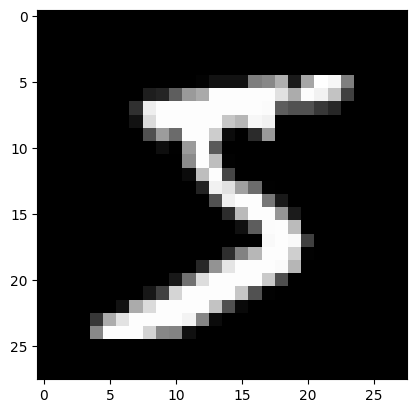

In [61]:
# visualize images for me
import matplotlib.pyplot as plt
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
print(y_train[0].item())

This metadata serves a similar purpose for `Tensor`s
as type metadata serves for other objects in Python
(and other programming languages).

That is, types tell us whether an object is an acceptable
input for or output of a function.
Many functions on `Tensor`s, like indexing,
matrix multiplication,
can only accept as input `Tensor`s of a certain shape and dimension
and will return as output `Tensor`s of a certain shape and dimension.

So printing `ndim` and `shape` to track
what's happening to `Tensor`s during a computation
is an important piece of the debugging toolkit!

We won't spend much time here on writing raw array math code in PyTorch,
nor will we spend much time on how PyTorch works.

> If you'd like to get better at writing PyTorch code,
try out
[these "Tensor Puzzles" by Sasha Rush](https://github.com/srush/Tensor-Puzzles).
We wrote a bit about what these puzzles reveal about programming
with arrays [here](https://twitter.com/charles_irl/status/1517991568266776577?s=20&t=i9cZJer0RPI2lzPIiCF_kQ).

> If you'd like to get a better understanging of the internals
of PyTorch, check out
[this blog post by Edward Yang](http://blog.ezyang.com/2019/05/pytorch-internals/).

As we'll see below,
`torch.nn` provides most of what we need
for building deep learning models.

The `Tensor`s inside of the `x_train` `Tensor`
aren't just any old blocks of numbers:
they're images of handwritten digits.
The `y_train` `Tensor` contains the identities of those digits.

Let's take a look at a random example:

In [62]:
# re-execute this cell for more samples
import random
import sys

import  text_recognizer.metadata.mnist as metadata 

import wandb  # just for some convenience methods that convert tensors to human-friendly datatypes

idx = random.randint(0, len(x_train))
example = x_train[idx]

print(y_train[idx])  # the label of the image
wandb.Image(example.reshape(*metadata.DIMS)).image  # the image itself

tensor(9)


We want to build a deep network that can take in an image
and return the number that's in the image.

We'll build that network
by fitting it to `x_train` and `y_train`.

We'll first do our fitting with just basic `torch` components and Python,
then we'll add in other `torch` gadgets and goodies
until we have a more realistic neural network fitting loop.

Later in the labs,
we'll see how to even more quickly build
performant, robust fitting loops
that have even more features
by using libraries built on top of PyTorch.

# Building a DNN using only `torch.Tensor` methods and Python

One of the really great features of PyTorch
is that writing code in PyTorch feels
very similar to writing other code in Python --
unlike other deep learning frameworks
that can sometimes feel like their own language
or programming paradigm.

This fact can sometimes be obscured
when you're using lots of library code,
so we start off by just using `Tensor`s and the Python standard library.

## Defining the model

We'll make the simplest possible neural network:
a single layer that performs matrix multiplication,
and adds a vector of biases.

We'll need values for the entries of the matrix,
which we generate randomly.

We also need to tell PyTorch that we'll
be taking gradients with respect to
these `Tensor`s later, so we use `requires_grad`.

In [63]:
import math

import torch


weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

We can combine our beloved Python operators,
like `+` and `*` and `@` and indexing,
to define the model.

In [64]:
def linear(x: torch.Tensor) -> torch.Tensor:
    return x @ weights + bias

We need to normalize our model's outputs with a `softmax`
to get our model to output something we can use
as a probability distribution --
the probability that the network assigns to each label for the image.

For that, we'll need some `torch` math functions,
like `torch.sum` and `torch.exp`.

We compute the logarithm of that softmax value
in part for numerical stability reasons
and in part because
[it is more natural to work with the logarithms of probabilities](https://youtu.be/LBemXHm_Ops?t=1071).

In [65]:
def log_softmax(x: torch.Tensor) -> torch.Tensor:
    return x - torch.log(torch.sum(torch.exp(x), axis=1))[:, None]

def model(xb: torch.Tensor) -> torch.Tensor:
    return log_softmax(linear(xb))

Typically, we split our dataset up into smaller "batches" of data
and apply our model to one batch at a time.

Since our dataset is just a `Tensor`,
we can pull that off just with indexing:

In [66]:
bs = 64  # batch size

xb = x_train[0:bs]  # a batch of inputs
outs = model(xb)  # outputs on that batch

print(outs[0], outs.shape)  # outputs on the first element of the batch

tensor([-1.9408, -2.5553, -1.8189, -2.4866, -2.6265, -2.7444, -1.8082, -2.3725,
        -2.6129, -2.7152], grad_fn=<SelectBackward0>) torch.Size([64, 10])


## Defining the loss and metrics

Our model produces outputs, but they are mostly wrong,
since we set the weights randomly.

How can we quantify just how wrong our model is,
so that we can make it better?

We want to compare the outputs and the target labels,
but the model outputs a probability distribution,
and the labels are just numbers.

We can take the label that had the highest probability
(the index of the largest output for each input,
aka the `argmax` over `dim`ension `1`)
and treat that as the model's prediction
for the digit in the image.

In [120]:
def accuracy(out: torch.Tensor, yb: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(out, dim=1)
    print("Accuracy preds:")
    print(preds)
    print(yb)
    print(
        """"
        """
    )
    return (preds == yb).float().mean()

If we run that function on our model's `out`put`s`,
we can confirm that the random model isn't doing well --
we expect to see that something around one in ten predictions are correct.

In [68]:
yb = y_train[0:bs]

acc = accuracy(outs, yb)

print(acc)

tensor(0.0156)


We can calculate how good our network is doing,
so are we ready to use optimization to make it do better?

Not yet!
To train neural networks, we use gradients
(aka derivatives).
So all of the functions we use need to be differentiable --
in particular they need to change smoothly so that a small change in input
can only cause a small change in output.

Our `argmax` breaks that rule
(if the values at index `0` and index `N` are really close together,
a tiny change can change the output by `N`)
so we can't use it.

If we try to run our `backward`s pass to get a gradient,
we get a `RuntimeError`:

In [69]:
try:
    acc.backward()
except RuntimeError as e:
    print(e)

element 0 of tensors does not require grad and does not have a grad_fn


So we'll need something else:
a differentiable function that gets smaller when
our model gets better, aka a `loss`.

The typical choice is to maximize the
probability the network assigns to the correct label.

We could try doing that directly,
but more generally,
we want the model's output probability distribution
to match what we provide it -- 
here, we claim we're 100% certain in every label,
but in general we allow for uncertainty.
We quantify that match with the
[cross entropy](https://charlesfrye.github.io/stats/2017/11/09/the-surprise-game.html).

Cross entropies
[give rise to most loss functions](https://youtu.be/LBemXHm_Ops?t=1316),
including more familiar functions like the
mean squared error and the mean absolute error.

We can calculate it directly from the outputs and target labels
using some cute tricks:

In [70]:
def cross_entropy(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return -output[range(target.shape[0]), target].mean()

loss_func = cross_entropy

With random guessing on a dataset with 10 equally likely options,
we expect our loss value to be close to the negative logarithm of 1/10:
the amount of entropy in a uniformly random digit.

In [71]:
print(loss_func(outs, yb), -torch.log(torch.tensor(1 / 10)))

tensor(2.3392, grad_fn=<NegBackward0>) tensor(2.3026)


Now we can call `.backward` without PyTorch complaining:

In [72]:
loss = loss_func(outs, yb)

loss.backward()

But wait, where are the gradients?
They weren't returned by `loss` above,
so where could they be?

They've been stored in the `.grad` attribute
of the parameters of our model,
`weights` and `bias`:

In [73]:
bias.grad

tensor([ 0.0124, -0.0303,  0.0318, -0.0126, -0.0392,  0.0381,  0.0416,  0.0209,
        -0.0155, -0.0473])

## Defining and running the fitting loop

We now have all the ingredients we need to fit a neural network to data:
- data (`x_train`, `y_train`)
- a network architecture with parameters (`model`, `weights`, and `bias`)
- a `loss_func`tion to optimize (`cross_entropy`) that supports `.backward` computation of gradients

We can put them together into a training loop
just using normal Python features,
like `for` loops, indexing, and function calls:

In [74]:
lr = 0.5  # learning rate hyperparameter
epochs = 2  # how many epochs to train for

for epoch in range(epochs):  # loop over the data repeatedly
    for ii in range((n - 1) // bs + 1):  # in batches of size bs, so roughly n / bs of them
        start_idx = ii * bs  # we are ii batches in, each of size bs
        end_idx = start_idx + bs  # and we want the next bs entires

        # pull batches from x and from y
        xb = x_train[start_idx:end_idx]
        yb = y_train[start_idx:end_idx]

        # run model
        pred = model(xb)

        # get loss
        loss = loss_func(pred, yb)

        # calculate the gradients with a backwards pass
        loss.backward()

        # update the parameters
        with torch.no_grad():  # we don't want to track gradients through this part!
            # SGD learning rule: update with negative gradient scaled by lr
            weights -= weights.grad * lr
            bias -= bias.grad * lr

            # ACHTUNG: PyTorch doesn't assume you're done with gradients
            #          until you say so -- by explicitly "deleting" them,
            #          i.e. setting the gradients to 0.
            weights.grad.zero_()
            bias.grad.zero_()

To check whether things are working,
we confirm that the value of the `loss` has gone down
and the `accuracy` has gone up:

In [75]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0834, grad_fn=<NegBackward0>) tensor(1.)


We can also run the model on a few examples
to get a sense for how it's doing --
always good for detecting bugs in our evaluation metrics!

In [119]:
# re-execute this cell for more samples
idx = random.randint(0, len(x_train))
example = x_train[idx:idx+1]

out = model(example)

print(out.argmax())
wandb.Image(example.reshape(28, 28)).image

tensor(1, device='cuda:0')


# Refactoring with core `torch.nn` components

This works!
But it's rather tedious and manual --
we have to track what the parameters of our model are,
apply the parameter updates to each one individually ourselves,
iterate over the dataset directly, etc.

It's also very literal:
many assumptions about our problem are hard-coded in the loop.
If our dataset was, say, stored in CSV files
and too large to fit in RAM,
we'd have to rewrite most of our training code.

For the next few sections,
we'll progressively refactor this code to
make it shorter, cleaner,
and more extensible
using tools from the sublibraries of PyTorch:
`torch.nn`, `torch.optim`, and `torch.utils.data`.

## Using `torch.nn.functional` for stateless computation

First, let's drop that `cross_entropy` and `log_softmax`
we implemented ourselves --
whenever you find yourself implementing basic mathematical operations
in PyTorch code you want to put in production,
take a second to check whether the code you need's not out
there in a library somewhere.
You'll get fewer bugs and faster code for less effort!

Both of those functions operated on their inputs
without reference to any global variables,
so we find their implementation in `torch.nn.functional`,
where stateless computations live.

In [77]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [78]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))  # should be unchanged from above!

tensor(0.0834, grad_fn=<NllLossBackward0>) tensor(1.)


## Using `torch.nn.Module` to define functions whose state is given by `torch.nn.Parameter`s

Perhaps the biggest issue with our setup is how we're handling state.

The `model` function refers to two global variables: `weights` and `bias`.
These variables are critical for it to run,
but they are defined outside of the function
and are manipulated willy-nilly by other operations.

This problem arises because of a fundamental tension in
deep neural networks.
We want to use them _as functions_ --
when the time comes to make predictions in production,
we put inputs in and get outputs out,
just like any other function.
But neural networks are fundamentally stateful,
because they are _parameterized_ functions,
and fiddling with the values of those parameters
is the purpose of optimization.

PyTorch's solution to this is the `nn.Module` class:
a Python class that is callable like a function
but tracks state like an object.

Whatever `Tensor`s representing state we want PyTorch
to track for us inside of our model
get defined as `nn.Parameter`s and attached to the model
as attributes.

In [79]:
from torch import nn


class MNISTLogistic(nn.Module):
    def __init__(self):
        super().__init__()  # the nn.Module.__init__ method does import setup, so this is mandatory
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

We define the computation that uses that state
in the `.forward` method.

Using some behind-the-scenes magic,
this method gets called if we treat
the instantiated `nn.Module` like a function by
passing it arguments.
You can give similar special powers to your own classes
by defining `__call__` "magic dunder" method
on them.

> <small> <small> We've separated the definition of the `.forward` method
from the definition of the class above and
attached the method to the class manually below.
We only do this to make the construction of the class
easier to read and understand in the context this notebook --
a neat little trick we'll use a lot in these labs.
Normally, we'd just define the `nn.Module` all at once.</small></small>

In [121]:
def forward(self, xb: torch.Tensor) -> torch.Tensor:
    return xb @ self.weights + self.bias

MNISTLogistic.forward = forward

model = MNISTLogistic()  # instantiated as an object
print(model(xb)[:4])  # callable like a function
loss = loss_func(model(xb), yb)  # composable like a function
loss.backward()  # we can still take gradients through it
print(model.weights.grad[::17,::2])  # and they show up in the .grad attribute

AttributeError: 'MNISTLogistic' object has no attribute 'weights'

But how do we apply our updates?
Do we need to access `model.weights.grad` and `model.weights`,
like we did in our first implementation?

Luckily, we don't!
We can iterate over all of our model's `torch.nn.Parameters`
via the `.parameters` method:

In [117]:
print(*list(model.parameters()), sep="\n")

Parameter containing:
tensor([-0.0148,  0.1073, -0.0056,  0.0169, -0.0246, -0.0849, -0.0097,  0.0282,
        -0.0272, -0.0025], device='cuda:0', requires_grad=True)


That means we no longer need to assume we know the names
of the model's parameters when we do our update --
we can reuse the same loop with different models.

Let's wrap all of that up into a single function to `fit` our model:

In [82]:
def fit():
    for epoch in range(epochs):
        for ii in range((n - 1) // bs + 1):
            start_idx = ii * bs
            end_idx = start_idx + bs
            xb = x_train[start_idx:end_idx]
            yb = y_train[start_idx:end_idx]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():  # finds params automatically
                    p -= p.grad * lr
                model.zero_grad()

fit()

and check that we didn't break anything,
i.e. that our model still gets accuracy much higher than 10%:

In [83]:
print(accuracy(model(xb), yb))

tensor(1.)


# Refactoring intermediate `torch.nn` components: network layers, optimizers, and data handling

Our model's state is being handled respectably,
our fitting loop is 2x shorter,
and we can train different models if we'd like.

But we're not done yet!
Many steps we're doing manually above
are already built in to `torch`.

## Using `torch.nn.Linear` for the model definition

As with our hand-rolled `cross_entropy`
that could be profitably replaced with
the industrial grade `nn.functional.cross_entropy`,
we should replace our bespoke linear layer
with something made by experts.

Instead of defining `nn.Parameters`,
effectively raw `Tensor`s, as attributes
of our `nn.Module`,
we can define other `nn.Module`s as attributes.
PyTorch assigns the `nn.Parameters`
of any child `nn.Module`s to the parent, recursively.

These `nn.Module`s are reusable --
say, if we want to make a network with multiple layers of the same type --
and there are lots of them already defined:

In [84]:
import textwrap

print("torch.nn.Modules:", *textwrap.wrap(", ".join(torch.nn.modules.__all__)), sep="\n\t")

torch.nn.Modules:
	Module, Identity, Linear, Conv1d, Conv2d, Conv3d, ConvTranspose1d,
	ConvTranspose2d, ConvTranspose3d, Threshold, ReLU, Hardtanh, ReLU6,
	Sigmoid, Tanh, Softmax, Softmax2d, LogSoftmax, ELU, SELU, CELU, GLU,
	GELU, Hardshrink, LeakyReLU, LogSigmoid, Softplus, Softshrink,
	MultiheadAttention, PReLU, Softsign, Softmin, Tanhshrink, RReLU,
	L1Loss, NLLLoss, KLDivLoss, MSELoss, BCELoss, BCEWithLogitsLoss,
	NLLLoss2d, PoissonNLLLoss, CosineEmbeddingLoss, CTCLoss,
	HingeEmbeddingLoss, MarginRankingLoss, MultiLabelMarginLoss,
	MultiLabelSoftMarginLoss, MultiMarginLoss, SmoothL1Loss,
	GaussianNLLLoss, HuberLoss, SoftMarginLoss, CrossEntropyLoss,
	Container, Sequential, ModuleList, ModuleDict, ParameterList,
	ParameterDict, AvgPool1d, AvgPool2d, AvgPool3d, MaxPool1d, MaxPool2d,
	MaxPool3d, MaxUnpool1d, MaxUnpool2d, MaxUnpool3d, FractionalMaxPool2d,
	FractionalMaxPool3d, LPPool1d, LPPool2d, LocalResponseNorm,
	BatchNorm1d, BatchNorm2d, BatchNorm3d, InstanceNorm1d, InstanceNorm2d,

We want the humble `nn.Linear`,
which applies the same
matrix multiplication and bias operation.

In [85]:
class MNISTLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)  # pytorch finds the nn.Parameters inside this nn.Module

    def forward(self, xb):
        return self.lin(xb)  # call nn.Linear.forward here

In [86]:
model = MNISTLogistic()
print(loss_func(model(xb), yb))  # loss is still close to 2.3

tensor(2.3085, grad_fn=<NllLossBackward0>)


We can see that the `nn.Linear` module is a "child"
of the `model`,
and we don't see the matrix of weights and the bias vector:

In [118]:
print(*list(model.children()))

[]


but if we ask for the model's `.parameters`,
we find them:

In [88]:
print(*list(model.parameters()), sep="\n")

Parameter containing:
tensor([[-0.0339,  0.0326,  0.0237,  ..., -0.0341,  0.0052, -0.0233],
        [ 0.0229,  0.0094,  0.0285,  ..., -0.0222, -0.0166,  0.0283],
        [ 0.0289,  0.0143, -0.0203,  ...,  0.0039, -0.0270, -0.0292],
        ...,
        [-0.0147,  0.0064,  0.0349,  ..., -0.0036, -0.0165,  0.0326],
        [-0.0204,  0.0057,  0.0072,  ...,  0.0341, -0.0122,  0.0035],
        [-0.0017, -0.0129,  0.0159,  ...,  0.0073, -0.0022,  0.0232]],
       requires_grad=True)
Parameter containing:
tensor([-0.0254,  0.0161, -0.0304,  0.0167,  0.0232, -0.0178,  0.0273, -0.0263,
        -0.0004,  0.0302], requires_grad=True)


## Applying gradients with `torch.optim.Optimizer`

Applying gradients to optimize parameters
and resetting those gradients to zero
are very common operations.

So why are we doing that by hand?
Now that our model is a `torch.nn.Module` using `torch.nn.Parameters`,
we don't have to --
we just need to point a `torch.optim.Optimizer`
at the parameters of our model.

While we're at it, we can also use a more sophisticated optimizer --
`Adam` is a common first choice.

In [89]:
from torch import optim


def configure_optimizer(model: nn.Module) -> optim.Optimizer:
    return optim.Adam(model.parameters(), lr=3e-4)

In [90]:
model = MNISTLogistic()
opt = configure_optimizer(model)

print("before training:", loss_func(model(xb), yb), sep="\n\t")

for epoch in range(epochs):
    for ii in range((n - 1) // bs + 1):
        start_idx = ii * bs
        end_idx = start_idx + bs
        xb = x_train[start_idx:end_idx]
        yb = y_train[start_idx:end_idx]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print("after training:", loss_func(model(xb), yb), sep="\n\t")

before training:
	tensor(2.2520, grad_fn=<NllLossBackward0>)
after training:
	tensor(0.8497, grad_fn=<NllLossBackward0>)


## Organizing data with `torch.utils.data.Dataset`

We're also manually handling the data.
First, we're independently and manually aligning
the inputs, `x_train`, and the outputs, `y_train`.

Aligned data is important in ML.
We want a way to combine multiple data sources together
and index into them simultaneously.

That's done with `torch.utils.data.Dataset`.
Just inherit from it and implement two methods to support indexing:
`__getitem__` and `__len__`.

We'll cheat a bit here and pull in the `BaseDataset`
class from the `text_recognizer` library,
so that we can start getting some exposure
to the codebase for the labs.

In [91]:
from text_recognizer.data.util import BaseDataset


train_ds = BaseDataset(x_train, y_train)

The cell below will pull up the documentation for this class,
which effectively just indexes into the two `Tensor`s simultaneously.

It can also apply transformations to the inputs and targets.
We'll see that later.

In [92]:
BaseDataset??

This makes our code a tiny bit cleaner:

In [93]:
model = MNISTLogistic()
opt = configure_optimizer(model)


for epoch in range(epochs):
    for ii in range((n - 1) // bs + 1):
        xb, yb = train_ds[ii * bs: ii * bs + bs]  # xb and yb in one line!
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.8454, grad_fn=<NllLossBackward0>)


## Batching up data with `torch.utils.data.DataLoader`

We're also still manually building our batches.

Making batches out of datasets is a core component of contemporary deep learning training workflows,
so unsurprisingly PyTorch offers a tool for it: the `DataLoader`.

We just need to hand our `Dataset` to the `DataLoader`
and choose a `batch_size`.

We can tune that parameter and other `DataLoader` arguments,
like `num_workers` and `pin_memory`,
to improve the performance of our training loop.
For more on the impact of `DataLoader` parameters on the behavior of PyTorch code, see
[this blog post and Colab](https://wandb.ai/wandb/trace/reports/A-Public-Dissection-of-a-PyTorch-Training-Step--Vmlldzo5MDE3NjU).

In [94]:
from torch.utils.data import DataLoader


train_ds = BaseDataset(x_train, y_train)
train_dataloader = DataLoader(train_ds, batch_size=bs)

In [95]:
def fit(self: nn.Module, train_dataloader: DataLoader):
    opt = configure_optimizer(self)

    for epoch in range(epochs):
        for xb, yb in train_dataloader:
            pred = self(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

MNISTLogistic.fit = fit

In [96]:
model = MNISTLogistic()

model.fit(train_dataloader)

print(loss_func(model(xb), yb))

tensor(0.8616, grad_fn=<NllLossBackward0>)


Compare the ten line `fit` function with our first training loop (reproduced below) --
much cleaner _and_ much more powerful!

```python
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for ii in range((n - 1) // bs + 1):
        start_idx = ii * bs
        end_idx = start_idx + bs
        xb = x_train[start_idx:end_idx]
        yb = y_train[start_idx:end_idx]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
```

## Swapping in another model

To see that our new `.fit` is more powerful,
let's use it with a different model.

Specifically, let's draw in the `MLP`,
or "multi-layer perceptron" model
from the `text_recognizer` library
in our codebase.

In [97]:
from text_recognizer.models.mlp import MLP


MLP.fit = fit  # attach our fitting loop

If you look in the `.forward` method of the `MLP`,
you'll see that it uses
some modules and functions we haven't seen, like
[`nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
and [`F.relu`](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html),
but otherwise fits the interface of our training loop:
the `MLP` is callable and it takes an `x` and returns a guess for the `y` labels.

In [98]:
MLP.forward??

If we look at the constructor, `__init__`,
we see that the `nn.Module`s (`fc` and `dropout`)
are initialized and attached as attributes.

In [99]:
MLP.__init__??

We also see that we are required to provide a `data_config`
dictionary and can optionally configure the module with `args`.

For now, we'll only do the bare minimum and specify
the contents of the `data_config`:
the `input_dims` for `x` and the `mapping`
from class index in `y` to class label,
which we can see are used in the `__init__` method.

In [100]:
digits_to_9 = list(range(10))
data_config = {"input_dims": (784,), "mapping": {digit: str(digit) for digit in digits_to_9}}
data_config

{'input_dims': (784,),
 'mapping': {0: '0',
  1: '1',
  2: '2',
  3: '3',
  4: '4',
  5: '5',
  6: '6',
  7: '7',
  8: '8',
  9: '9'}}

In [101]:
model = MLP(data_config)
model

MLP(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

The resulting `MLP` is a bit larger than our `MNISTLogistic` model:

In [102]:
model.fc1.weight

Parameter containing:
tensor([[ 0.0333, -0.0130,  0.0121,  ...,  0.0258,  0.0267, -0.0260],
        [-0.0355, -0.0196,  0.0077,  ...,  0.0120,  0.0226, -0.0094],
        [ 0.0266, -0.0041, -0.0243,  ...,  0.0190, -0.0025, -0.0269],
        ...,
        [-0.0254,  0.0261, -0.0066,  ..., -0.0137, -0.0318,  0.0285],
        [ 0.0057, -0.0131,  0.0205,  ...,  0.0013,  0.0145, -0.0113],
        [ 0.0120, -0.0147, -0.0260,  ...,  0.0243,  0.0258, -0.0232]],
       requires_grad=True)

But that doesn't matter for our fitting loop,
which happily optimizes this model on batches from the `train_dataloader`,
though it takes a bit longer.

In [103]:
%%time

print("before training:", loss_func(model(xb), yb))

train_ds = BaseDataset(x_train, y_train)
train_dataloader = DataLoader(train_ds, batch_size=bs)
fit(model, train_dataloader)

print("after training:", loss_func(model(xb), yb))

before training: tensor(2.3451, grad_fn=<NllLossBackward0>)
after training: tensor(0.2463, grad_fn=<NllLossBackward0>)
CPU times: user 48min 7s, sys: 682 ms, total: 48min 8s
Wall time: 7min 7s


# Extra goodies: data organization, validation, and acceleration

Before we've got a DNN fitting loop that's welcome in polite company,
we need three more features:
organized data loading code, validation, and GPU acceleration.

## Making the GPU go brrrrr

Everything we've done so far has been on
the central processing unit of the computer, or CPU.
When programming in Python,
it is on the CPU that
almost all of our code becomes concrete instructions
that cause a machine move around electrons.

That's okay for small-to-medium neural networks,
but computation quickly becomes a bottleneck that makes achieving
good performance infeasible.

In general, the problem of CPUs,
which are general purpose computing devices,
being too slow is solved by using more specialized accelerator chips --
in the extreme case, application-specific integrated circuits (ASICs)
that can only perform a single task,
the hardware equivalents of
[sword-billed hummingbirds](https://en.wikipedia.org/wiki/Sword-billed_hummingbird) or
[Canada lynx](https://en.wikipedia.org/wiki/Canada_lynx).

Luckily, really excellent chips
for accelerating deep learning are readily available
as a consumer product:
graphics processing units (GPUs),
which are designed to perform large matrix multiplications in parallel.
Their name derives from their origins
applying large matrix multiplications to manipulate shapes and textures
in for graphics engines for video games and CGI.

If your system has a GPU and the right libraries installed
for `torch` compatibility,
the cell below will print information about its state.

In [104]:
if torch.cuda.is_available():
    !nvidia-smi
else:
    print("☹️")

Tue Oct  3 23:54:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:B3:00.0 Off |                  Off |
| 59%   78C    P2   117W / 140W |  11493MiB / 16108MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

PyTorch is designed to allow for computation to occur both on the CPU and the GPU --
even simultaneously, which can be critical for high performance.

So once we start using acceleration, we need to be more precise about where the
data inside our `Tensor`s lives --
on which physical `torch.device` it can be found.

On compatible systems, the cell below will
move all of the model's parameters `.to` the GPU
(another good reason to use `torch.nn.Parameter`s and not handle them yourself!)
and then move a batch of inputs and targets there as well
before applying the model and calculating the loss.

To confirm this worked, look for the name of the device in the output of the cell,
alongside other information about the loss `Tensor`.

In [105]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

loss_func(model(xb.to(device)), yb.to(device))

tensor(0.1630, device='cuda:0', grad_fn=<NllLossBackward0>)

Rather than rewrite our entire `.fit` function,
we'll make use of the features of the `text_recognizer.data.utils.BaseDataset`.

Specifically,
we can provide a `transform` that is called on the inputs
and a `target_transform` that is called on the labels
before they are returned.
In the FSDL codebase,
this feature is used for data preparation, like
reshaping, resizing,
and normalization.

We'll use this as an opportunity to put the `Tensor`s on the appropriate device.

In [106]:
def push_to_device(tensor):
    return tensor.to(device)

train_ds = BaseDataset(x_train, y_train, transform=push_to_device, target_transform=push_to_device)
train_dataloader = DataLoader(train_ds, batch_size=bs)

We don't need to change anything about our fitting code to run it on the GPU!

Note: given the small size of this model and the data,
the speedup here can sometimes be fairly moderate (like 2x).
For larger models, GPU acceleration can easily lead to 50-100x faster iterations.

In [107]:
%%time

model = MLP(data_config)
model.to(device)

model.fit(train_dataloader)

print(loss_func(model(push_to_device(xb)), push_to_device(yb)))

tensor(0.2538, device='cuda:0', grad_fn=<NllLossBackward0>)
CPU times: user 48.4 s, sys: 60.1 ms, total: 48.4 s
Wall time: 48.5 s


Writing high performance GPU-accelerated neural network code is challenging.
There are many sharp edges, so the default
strategy is imitation (basing all work on existing verified quality code)
and conservatism bordering on paranoia about change.
For a casual introduction to some of the core principles, see
[Horace He's blogpost](https://horace.io/brrr_intro.html).

## Adding validation data and organizing data code with a `DataModule`

Just doing well on data you've seen before is not that impressive --
the network could just memorize the label for each input digit.

We need to check performance on a set of data points that weren't used
directly to optimize the model,
commonly called the validation set.

We already downloaded one up above,
but that was all the way at the beginning of the notebook,
and I've already forgotten about it.

In general, it's easy for data-loading code,
the redheaded stepchild of the ML codebase,
to become messy and fall out of sync.

A proper `DataModule` collects up all of the code required
to prepare data on a machine,
sets it up as a collection of `Dataset`s,
and turns those `Dataset`s into `DataLoader`s,
as below:

In [108]:
class MNISTDataModule:
    url = "https://github.com/pytorch/tutorials/raw/master/_static/"
    filename = "mnist.pkl.gz"
    
    def __init__(self, dir, bs=32):
        self.dir = dir
        self.bs = bs
        self.path = self.dir / self.filename

    def prepare_data(self):
        if not (self.path).exists():
            content = requests.get(self.url + self.filename).content
            self.path.open("wb").write(content)

    def setup(self):
        with gzip.open(self.path, "rb") as f:
            ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

        x_train, y_train, x_valid, y_valid = map(
            torch.tensor, (x_train, y_train, x_valid, y_valid)
            )
        
        self.train_ds = BaseDataset(x_train, y_train, transform=push_to_device, target_transform=push_to_device)
        self.valid_ds = BaseDataset(x_valid, y_valid, transform=push_to_device, target_transform=push_to_device)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds, batch_size=self.bs, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valid_ds, batch_size=2 * self.bs, shuffle=False)

We'll cover `DataModule`s in more detail later.

We can now incorporate our `DataModule`
into the fitting pipeline
by calling its methods as needed:

In [109]:
def fit(self: nn.Module, datamodule):
    datamodule.prepare_data()
    datamodule.setup()

    val_dataloader = datamodule.val_dataloader()
    
    self.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(self(xb), yb) for xb, yb in val_dataloader)

    print("before start of training:", valid_loss / len(val_dataloader))

    opt = configure_optimizer(self)
    train_dataloader = datamodule.train_dataloader()
    for epoch in range(epochs):
        self.train()
        for xb, yb in train_dataloader:
            pred = self(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        self.eval()
        with torch.no_grad():
            valid_loss = sum(loss_func(self(xb), yb) for xb, yb in val_dataloader)

        print(epoch, valid_loss / len(val_dataloader))


MNISTLogistic.fit = fit
MLP.fit = fit

Now we've substantially cut down on the "hidden state" in our fitting code:
if you've defined the `MNISTLogistic` and `MNISTDataModule` classes,
then you can train a network with just the cell below.

In [110]:
model = MLP(data_config)
model.to(device)

datamodule = MNISTDataModule(dir=path, bs=32)

model.fit(datamodule=datamodule)

before start of training: tensor(2.3024, device='cuda:0')
0 tensor(0.1667, device='cuda:0')
1 tensor(0.1167, device='cuda:0')


You may have noticed a few other changes in the `.fit` method:

- `self.eval` vs `self.train`:
it's helpful to have features of neural networks that behave differently in `train`ing
than they do in production or `eval`uation.
[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
and
[BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
are among the most popular examples.
We need to take this into account now that we
have a validation loop.
- The return of `torch.no_grad`: in our first few implementations,
we had to use `torch.no_grad` to avoid tracking gradients while we were updating parameters.
Now, we need to use it to avoid tracking gradients during validation.

This is starting to get a bit hairy again!
We're back up to about 30 lines of code,
right where we started
(but now with way more features!).

Much like `torch.nn` provides useful tools and interfaces for
defining neural networks,
iterating over batches,
and calculating gradients,
frameworks on top of PyTorch, like
[PyTorch Lightning](https://pytorch-lightning.readthedocs.io/),
provide useful tools and interfaces
for an even higher level of abstraction over neural network training.

For serious deep learning codebases,
you'll want to use a framework at that level of abstraction --
either one of the popular open frameworks or one developed in-house.

For most of these frameworks,
you'll still need facility with core PyTorch:
at least for defining models and
often for defining data pipelines as well.

# Exercises

### 🌟 Try out different hyperparameters for the `MLP` and for training.

The `MLP` class is configured via the `args` argument to its constructor,
which can set the values of hyperparameters like the width of layers and the degree of dropout:

In [111]:
MLP.__init__??

As the type signature indicates, `args` is an `argparse.Namespace`.
[`argparse` is used to build command line interfaces in Python](https://realpython.com/command-line-interfaces-python-argparse/),
and later on we'll see how to configure models
and launch training jobs from the command line
in the FSDL codebase.

For now, we'll do it by hand, by passing a dictionary to `Namespace`.

Edit the cell below to change the `args`, `epochs`, and `b`atch `s`ize.

Can you get a final `valid`ation `acc`uracy of 98%?
Can you get to 95% 2x faster than the baseline `MLP`?

In [112]:
%%time 
from argparse import Namespace  # you'll need this

args = None  # edit this

epochs = 2  # used in fit
bs = 32  # used by the DataModule


# used in fit, play around with this if you'd like
def configure_optimizer(model: nn.Module) -> optim.Optimizer:
    return optim.Adam(model.parameters(), lr=3e-4)


model = MLP(data_config, args=args)
model.to(device)

datamodule = MNISTDataModule(dir=path, bs=bs)

model.fit(datamodule=datamodule)

before start of training: tensor(2.3002, device='cuda:0')
0 tensor(0.1655, device='cuda:0')
1 tensor(0.1145, device='cuda:0')
CPU times: user 1min 10s, sys: 743 ms, total: 1min 11s
Wall time: 1min 10s


In [113]:
val_dataloader = datamodule.val_dataloader()
valid_acc = sum(accuracy(model(xb), yb) for xb, yb in val_dataloader) / len(val_dataloader)
valid_acc

tensor(0.9674, device='cuda:0')

### 🌟🌟🌟 Write your own `nn.Module`.

Designing new models is one of the most fun
aspects of building an ML-powered application.

Can you make an `nn.Module` that looks different from
the standard `MLP` but still gets 98% validation accuracy or higher?
You might start from the `MLP` and
[add more layers to it](https://i.imgur.com/qtlP5LI.png)
while adding more bells and whistles.
Take care to keep the shapes of the `Tensor`s aligned as you go.

Here's some tricks you can try that are especially helpful with deeper networks:
- Add [`BatchNorm`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
layers, which can improve
[training stability and loss conditioning](https://myrtle.ai/how-to-train-your-resnet-7-batch-norm/)
- Add a linear "skip connection" layer that is applied to the inputs and whose outputs are added directly to the last layer's outputs
- Use other [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions),
like [selu](https://pytorch.org/docs/stable/generated/torch.nn.functional.selu.html)
or [mish](https://pytorch.org/docs/stable/generated/torch.nn.functional.mish.html)

If you want to make an `nn.Module` that can have different depths,
check out the
[`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) class.

In [114]:
class YourModel(nn.Module):
    def __init__(self):  # add args and kwargs here as you like
        super().__init__()
        # use those args and kwargs to set up the submodules
        self.ps = nn.Parameter(torch.zeros(10))

    def forward(self, xb):  # overwrite this to use your nn.Modules from above
        xb = torch.stack([self.ps for ii in range(len(xb))])
        return xb
    
    
YourModel.fit = fit  # don't forget this!

In [115]:
model = YourModel()
model.to(device)

datamodule = MNISTDataModule(dir=path, bs=bs)

model.fit(datamodule=datamodule)

before start of training: tensor(2.3026, device='cuda:0')
0 tensor(2.3018, device='cuda:0')
1 tensor(2.3019, device='cuda:0')


In [116]:
val_dataloader = datamodule.val_dataloader()
valid_acc = sum(accuracy(model(xb), yb) for xb, yb in val_dataloader) / len(val_dataloader)
valid_acc

tensor(0.1065, device='cuda:0')